#### Confounding variable analysis

In [81]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from scipy import stats

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [82]:
folder = '/root/capsule/data/filtered_data_20240911/filtered_data_20240911.csv'
df = pd.read_csv(folder)

In [83]:
# Let's look at individual trainer foraging performance scores first 

indiv_df = df[['subject_id', 'user_name', 'foraging_performance', 'session_date']]

# Convert session_date to dates 
indiv_df['session_date'] = pd.to_datetime(indiv_df['session_date'])

# Abbreviate for readability in plots 
indiv_df['date'] = indiv_df['session_date'].dt.strftime('%b %d')

# Filter for selected user
user = 'Bowen Tan'

bt_df = indiv_df[indiv_df['user_name'] == user]

bt_df.head()

/tmp/ipykernel_13243/3448928391.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_df['session_date'] = pd.to_datetime(indiv_df['session_date'])
/tmp/ipykernel_13243/3448928391.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_df['date'] = indiv_df['session_date'].dt.strftime('%b %d')


,subject_id,user_name,foraging_performance,session_date,date
0,730942,Bowen Tan,0.748154,2024-09-10,Sep 10
1,741211,Bowen Tan,0.760353,2024-09-10,Sep 10
2,736198,Bowen Tan,0.700040,2024-09-10,Sep 10
3,730945,Bowen Tan,0.557400,2024-09-10,Sep 10
4,741213,Bowen Tan,0.738699,2024-09-10,Sep 10


In [84]:
# Create pivot tables for average foraging performance with dims: (subject x time)

bt_pivot_table = bt_df.pivot_table(
    values='foraging_performance', 
    index='subject_id', 
    columns='date',
    aggfunc='mean',
    fill_value=0
)

In [85]:
# Scaling average pivot table values and create new dataframe
scaler = StandardScaler()

scaled_fp_values = scaler.fit_transform(bt_pivot_table.values)


bt_df = pd.DataFrame(scaled_fp_values, index=bt_pivot_table.index, columns=bt_pivot_table.columns)

other_users_subjects = indiv_df[indiv_df['user_name'] != user]['subject_id'].unique()

bt_df['trained_by_others'] = bt_df.index.isin(other_users_subjects)

bt_df = bt_df[bt_df['trained_by_others'] == False]

# Drop last date in dataframe

last_date = bt_df.columns[-2]

bt_df = bt_df.drop(columns=[last_date])

bt_df.head(20)

date,Aug 05,Aug 06,Aug 07,Aug 08,Aug 09,Aug 10,Aug 11,Aug 12,Aug 13,Aug 14,...,Aug 30,Aug 31,Sep 01,Sep 02,Sep 03,Sep 04,Sep 05,Sep 06,Sep 09,trained_by_others
subject_id,,,,,,,,,,,,,,,,,,,,,
728568,-0.687524,-0.618405,-0.702375,-0.702313,-0.698847,-0.704941,-0.696695,-0.694442,-0.705473,-0.699204,...,-0.616128,-0.617099,-0.618937,-0.616465,-0.614156,-0.617932,-0.619292,-0.617883,-0.617461,False
728570,-0.687524,-0.618405,-0.702375,-0.702313,-0.698847,-0.704941,-0.696695,-0.694442,-0.705473,-0.699204,...,-0.616128,-0.617099,-0.618937,-0.616465,-0.614156,-0.617932,-0.619292,-0.617883,-0.617461,False
730942,-0.687524,-0.618405,-0.702375,-0.702313,-0.698847,-0.704941,-0.696695,-0.694442,-0.705473,-0.699204,...,1.729636,1.677142,1.604150,1.787365,1.489108,1.589891,1.553192,1.604415,1.518844,False
730945,-0.687524,-0.618405,-0.702375,-0.702313,-0.698847,-0.704941,-0.696695,-0.694442,-0.705473,-0.699204,...,1.184842,1.238055,1.397050,1.226965,1.172034,1.343158,1.774801,1.534199,1.306391,False
736198,-0.687524,-0.618405,-0.702375,-0.702313,-0.698847,-0.704941,-0.696695,-0.694442,-0.705473,-0.699204,...,1.794209,1.625964,1.751708,1.533040,1.960493,1.631845,1.628643,1.433804,1.747635,False
736199,1.008201,1.541689,1.478275,1.030016,1.305704,1.511008,1.736301,1.453895,1.343733,1.638606,...,-0.616128,-0.617099,-0.618937,-0.616465,-0.614156,-0.617932,-0.619292,-0.617883,-0.617461,False
736200,0.959613,1.392668,1.117308,1.470923,1.511326,1.453323,1.096381,0.759220,1.197451,0.992307,...,-0.616128,-0.617099,-0.618937,-0.616465,-0.614156,-0.617932,-0.619292,-0.617883,-0.617461,False
736202,1.156769,1.829191,1.672068,1.327340,0.861523,1.190922,1.239133,1.579023,1.569687,1.658032,...,-0.616128,-0.617099,-0.618937,-0.616465,-0.614156,-0.617932,-0.619292,-0.617883,-0.617461,False
736203,1.885435,1.614878,1.561797,1.364337,1.469137,1.516049,1.863807,1.567779,1.493998,1.158383,...,-0.616128,-0.617099,-0.618937,-0.616465,-0.614156,-0.617932,-0.619292,-0.617883,-0.617461,False


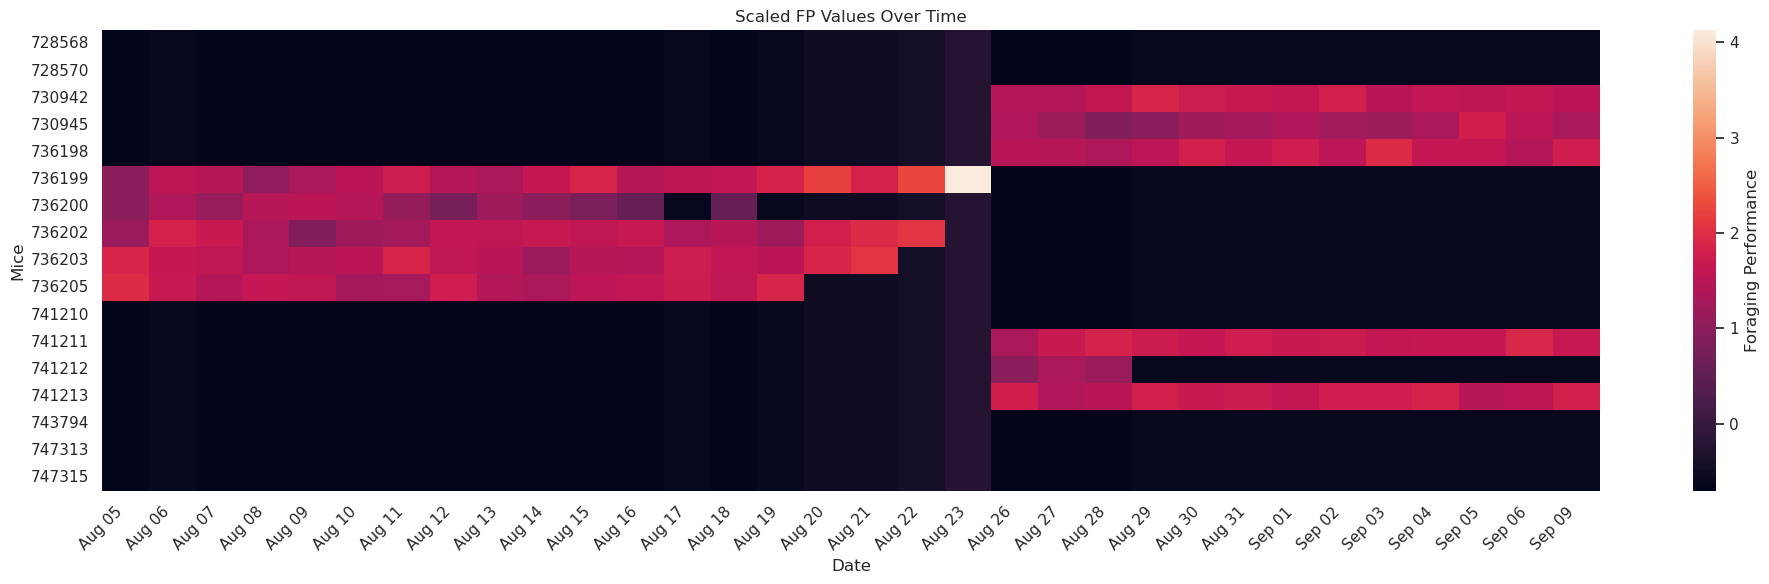

In [86]:
# Exclude float column 
bt_df_heatmap = bt_df.drop(columns='trained_by_others')

# Plot foraging performance heatmap
sns.set_theme()

plt.figure(figsize=(20,6))
sns.heatmap(data=bt_df_heatmap, cbar_kws={'label': 'Foraging Performance'})
plt.xticks(rotation=45, ha='right')
plt.title('Scaled FP Values Over Time')
plt.xlabel('Date')
plt.ylabel('Mice')

plt.tight_layout()

plt.show()

In [87]:
# Reshape dataframe
bt_df_long = bt_df_heatmap.reset_index().melt(id_vars='subject_id', var_name='date', value_name='foraging_performance')
bt_df_long['session_date'] = pd.to_datetime(bt_df_long['date'] + ' 2023', format='%b %d %Y') # Add back session date in date-time format

# Sort values
bt_df_long = bt_df_long.sort_values(['subject_id', 'session_date'])

bt_df_long

,subject_id,date,foraging_performance,session_date
0,728568,Aug 05,-0.687524,2023-08-05
17,728568,Aug 06,-0.618405,2023-08-06
34,728568,Aug 07,-0.702375,2023-08-07
51,728568,Aug 08,-0.702313,2023-08-08
68,728568,Aug 09,-0.698847,2023-08-09
...,...,...,...,...
475,747315,Sep 03,-0.614156,2023-09-03
492,747315,Sep 04,-0.617932,2023-09-04
509,747315,Sep 05,-0.619292,2023-09-05
526,747315,Sep 06,-0.617883,2023-09-06


In [88]:
# Find gaps in data

bt_df_long['days_since_last_session'] = bt_df_long.groupby('subject_id')['session_date'].diff().dt.days

# Define threshold for gaps

gap_threshold = 2
bt_df_long['is_gap'] = bt_df_long['days_since_last_session'] > gap_threshold

bt_df_long

,subject_id,date,foraging_performance,session_date,days_since_last_session,is_gap
0,728568,Aug 05,-0.687524,2023-08-05,NaN,False
17,728568,Aug 06,-0.618405,2023-08-06,1.0,False
34,728568,Aug 07,-0.702375,2023-08-07,1.0,False
51,728568,Aug 08,-0.702313,2023-08-08,1.0,False
68,728568,Aug 09,-0.698847,2023-08-09,1.0,False
...,...,...,...,...,...,...
475,747315,Sep 03,-0.614156,2023-09-03,1.0,False
492,747315,Sep 04,-0.617932,2023-09-04,1.0,False
509,747315,Sep 05,-0.619292,2023-09-05,1.0,False
526,747315,Sep 06,-0.617883,2023-09-06,1.0,False


In [89]:
# Analyze gaps

gap_summary = bt_df_long.groupby('subject_id').agg({
    'is_gap': 'sum',
    'days_since_last_session': lambda x: x[x > gap_threshold].sum()
}).rename(columns={'is_gap': 'num_gaps', 'days_since_last_session': 'total_gap_days'})

print(gap_summary)

            num_gaps  total_gap_days
subject_id                          
728568             2             6.0
728570             2             6.0
730942             2             6.0
730945             2             6.0
736198             2             6.0
736199             2             6.0
736200             2             6.0
736202             2             6.0
736203             2             6.0
736205             2             6.0
741210             2             6.0
741211             2             6.0
741212             2             6.0
741213             2             6.0
743794             2             6.0
747313             2             6.0
747315             2             6.0


In [90]:
# Look at foraging performance change at gaps

bt_df_long['prev_performance'] = bt_df_long.groupby('subject_id')['foraging_performance'].shift(1)
bt_df_long['performance_change'] = bt_df_long['foraging_performance'] - bt_df_long['prev_performance']
bt_df_long['post_gap_performance_change'] = bt_df_long.apply(lambda row: row['performance_change'] if row['is_gap'] else np.nan, axis=1)

bt_df_long

,subject_id,date,foraging_performance,session_date,days_since_last_session,is_gap,prev_performance,performance_change,post_gap_performance_change
0,728568,Aug 05,-0.687524,2023-08-05,NaN,False,NaN,NaN,NaN
17,728568,Aug 06,-0.618405,2023-08-06,1.0,False,-0.687524,0.069119,NaN
34,728568,Aug 07,-0.702375,2023-08-07,1.0,False,-0.618405,-0.083970,NaN
51,728568,Aug 08,-0.702313,2023-08-08,1.0,False,-0.702375,0.000062,NaN
68,728568,Aug 09,-0.698847,2023-08-09,1.0,False,-0.702313,0.003466,NaN
...,...,...,...,...,...,...,...,...,...
475,747315,Sep 03,-0.614156,2023-09-03,1.0,False,-0.616465,0.002309,NaN
492,747315,Sep 04,-0.617932,2023-09-04,1.0,False,-0.614156,-0.003776,NaN
509,747315,Sep 05,-0.619292,2023-09-05,1.0,False,-0.617932,-0.001360,NaN
526,747315,Sep 06,-0.617883,2023-09-06,1.0,False,-0.619292,0.001409,NaN


In [91]:
# Calculate average performance change after each gap 

gap_effect = bt_df_long.groupby('subject_id')['post_gap_performance_change'].mean()

In [92]:
# Time series analysis for 1 mouse

subject_ts = bt_df_long[bt_df_long['subject_id'] == bt_df_long['subject_id'].iloc[0]].set_index('session_date')['foraging_performance']

subject_ts = subject_ts.sort_index()
subject_ts = subject_ts[~subject_ts.index.duplicated(keep='first')]

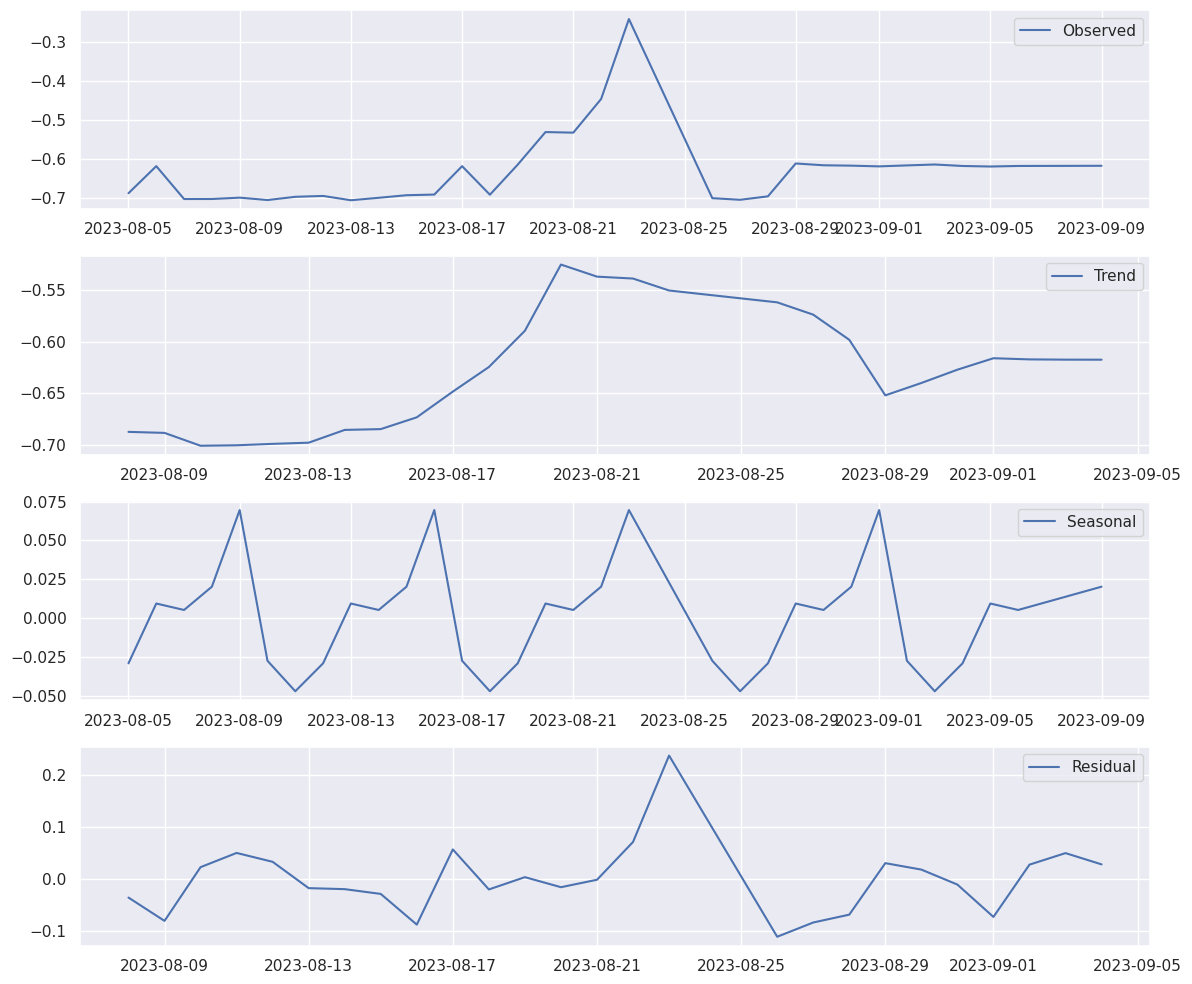

In [93]:

if len(subject_ts) >= 14: 
    decomposition = seasonal_decompose(subject_ts, model='additive', period=7)
    
    # Plot the decomposition
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(subject_ts, label='Observed')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data points for seasonal decomposition")